In [1]:
import torch
import torchcfm
import sys
from thesis.fit.vae import VAE
from thesis.data.twomoons import TwoMoonsDataModule

/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

In [2]:
model=VAE.load_from_checkpoint("/beegfs/desy/user/kaechben/thesis_experiments/thesis_experiments/chacsp08/checkpoints/epoch=49_step=50000-EMA.ckpt")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


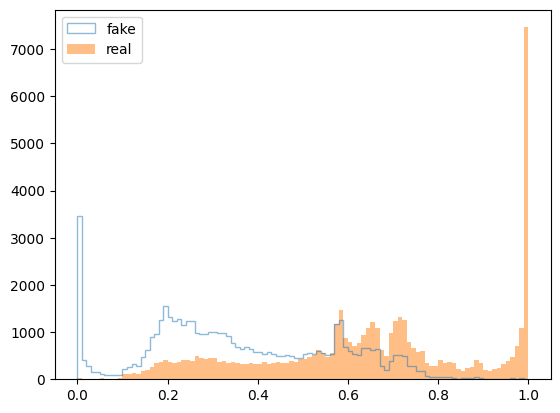

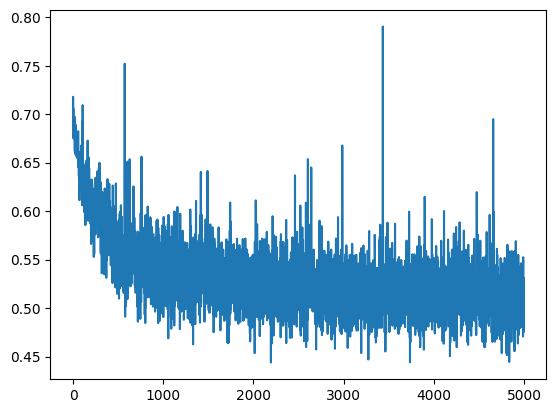

In [8]:
%load_ext autoreload

from thesis.data.twomoons import TwoMoonsDataModule
from thesis.models.gans import GANModel
from torch.nn.functional import binary_cross_entropy
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
data = TwoMoonsDataModule()
data.setup()
test_discriminator=GANModel(nfeatures=2, nblocks=2,nunits=64,gen=False,disc=True,batch_norm=True,).to(model.device)
opt_d=torch.optim.Adam(test_discriminator.parameters(),lr=0.01)
losses=[]
for _ in range(5):
    for batch in data.train_dataloader():


        opt_d.zero_grad()
        x,y=batch
        with torch.no_grad():
            z=torch.normal(0, 1, size=(x.shape[0], 2), device=model.device)
            xhat=model(z)

        x=x.to(model.device)
        x=torch.cat([x,xhat],dim=0)
        y=torch.cat([torch.ones_like(y),torch.zeros_like(y)],dim=0).unsqueeze(1).to(model.device)
        d_loss=binary_cross_entropy(test_discriminator(x).sigmoid(),y)
        d_loss.backward()
        losses.append(d_loss.item())
        opt_d.step()
test_discriminator.eval()

with torch.no_grad():
    x=(torch.from_numpy(make_moons(100*x.shape[0],noise=0.05)[0]).float().to(model.device)-data.mu)/data.std
    z=torch.normal(0, 1, size=(x.shape[0], 2), device=model.device)
    xhat=model(z)
    x=torch.cat((x,xhat),dim=0).to(model.device)
    y=torch.cat((torch.ones_like(xhat[:,0]),torch.zeros_like(xhat[:,0])),dim=0).to(model.device)
    yhat=test_discriminator(x.float()).sigmoid()
    acc=(yhat.round().squeeze()==y.squeeze()).float().mean()

_,b,_=plt.hist(yhat[y==0].cpu().numpy(),bins=np.linspace(0,1,101),label="fake",alpha=0.5,histtype="step")
plt.hist(yhat[y==1].cpu().numpy(),bins=b,label="real",alpha=0.5)
plt.legend()

plt.show()
plt.plot(losses)

In [4]:
test_discriminator.train()
print(test_discriminator(x).mean())
test_discriminator.eval()
print(test_discriminator(x).mean())

tensor(0.2261, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2880, device='cuda:0', grad_fn=<MeanBackward0>)


In [11]:
(yhat.round()==y).float().mean()

tensor(0.5000)

In [16]:
(yhat.round().squeeze()==y.squeeze()).sum().float()/y.shape[0]

tensor(0.7202)